In [1]:
import numpy as np
import pandas as pd
import json

import tifffile
import cv2

from shapely.geometry import Polygon
from PIL import Image, ImageDraw

from typing import List, Dict, Any

import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
class CFG:
    img_dir = "train_images"
    ann_dir = "train_annotations"
    meta_path = "train.csv"
    organs = ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']
    
meta = pd.read_csv(CFG.meta_path)

In [3]:

def read_tiff(path, scale=None, verbose=0): 
    image = tifffile.imread(path)
    if len(image.shape) == 5:
        image = image.squeeze().transpose(1, 2, 0)
    
    if verbose:
        print(f"[{path}] Image shape: {image.shape}")
    
    if scale:
        new_size = (image.shape[1] // scale, image.shape[0] // scale)
        image = cv2.resize(image, new_size)
        
        if verbose:
            print(f"[{path}] Resized Image shape: {image.shape}")
        
    mx = np.max(image)
    image = image.astype(np.float32)
    if mx:
        image /= mx 
    return image

def mask2rle(img): 
  
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle2mask(mask_rle, shape=(1600,256)): 

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [4]:
class FTU:
    def __init__(self, poly: Polygon, px_size: float) -> None:
        self.poly = poly
        self.px_size = px_size

        self.area_units = self.poly.area
        self.perimeter_units = self.poly.length
        self.centroid = self.poly.centroid

        self.area = self._compute_area_micrometers()
        self.polsby_popper = self._compute_polsby_popper()

    def _compute_area_micrometers(self) -> float:
        area_per_unit = self.px_size**2
        return float(self.area_units * area_per_unit)

    def _compute_polsby_popper(self) -> float:
        num = 4 * np.pi * self.area_units
        den = self.perimeter_units**2
        return num / den

In [5]:
class Organ:
    def __init__(self, img_id: int) -> None:
        # vars
        self.img_id = img_id
        self.polys: List[FTU] = list()
        self.sample = meta[meta.id == img_id]

        self.organ_type = self.sample.organ.values[0]
        self.pixel_size = self.sample.pixel_size.values[0]
        self.age = self.sample.age.values[0]
        self.sex = self.sample.sex.values[0]
        self.data_source = self.sample.data_source.values[0]

        self.img = read_tiff(f"{CFG.img_dir}/{img_id}.tiff")
        self.img_pil = Image.open(f"{CFG.img_dir}/{img_id}.tiff")
        self.mask = rle2mask(self.sample.rle.values[0], (self.img.shape[1], self.img.shape[0]))
        
        # fill polys with FTUs
        f = open(f"{CFG.ann_dir}/{img_id}.json")
        poly_json = json.load(f)
        f.close()
        for p in poly_json:
            poly = Polygon(p)
            self.polys.append(FTU(poly, self.pixel_size))

    def __len__(self) -> int:
        return len(self.polys)

    def print_meta(self):
        print(f"organ_type: {self.organ_type}")
        print(f"pixel_size: {self.pixel_size}")
        print(f"age: {self.age}")
        print(f"sex: {self.sex}")
        print(f"data_source: {self.data_source}")
        
    def compare_poly_to_true_area(self) -> float:
        true_area = np.count_nonzero(self.mask)

        poly_area = 0
        for poly in self.polys:
            poly_area += poly.area_units

        return true_area - poly_area

    def get_area_info(self) -> Dict[str, Any]:
        areas = [poly.area for poly in self.polys]
        avg_area = np.mean(areas)
        return {
            "areas": areas,
            "avg_area" : avg_area
        }

    def get_polsby_popper_info(self) -> Dict[str, Any]:
        pp = [poly.polsby_popper for poly in self.polys]
        avg_pp = np.mean(pp)
        return {
            "polsby_poppers" : pp,
            "avg_polsby_popper" : avg_pp
        }

    def display(self, info: str):
        plt.figure(figsize=(20,10))
        plt.imshow(self.img)

        for ftu in self.polys:
            x, y = ftu.poly.exterior.xy 
            plt.plot(x, y, c="blue")
            plt.fill(x, y, c="white") 
            if info == "area":
                plt.text(ftu.centroid.x, ftu.centroid.y, round(ftu.area), fontsize=10, horizontalalignment="center")
            elif info == "polsby_popper":
                plt.text(ftu.centroid.x, ftu.centroid.y, round(ftu.polsby_popper, 3), fontsize=10, horizontalalignment="center")

        if info == "area":
            plt.title(f"Organ {self.img_id} - Area - Size")
        elif info == "polsby_popper":
            plt.title(f"Organ {self.img_id} - Polsby Popper - Compactness")
            
        plt.show()

num FTUs: 22
organ_type: prostate
pixel_size: 0.4
age: 76.0
sex: Male
data_source: HPA


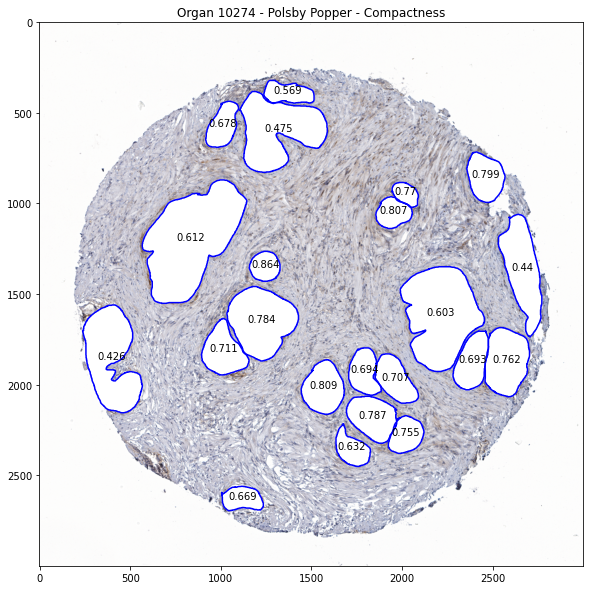

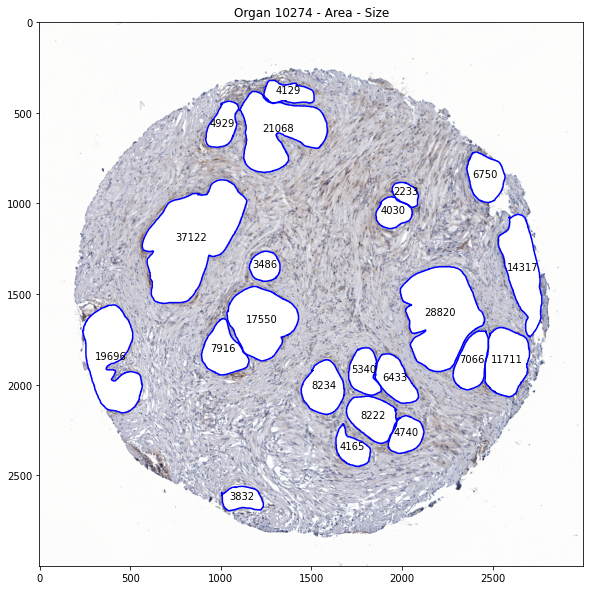

In [6]:
o = Organ(10274)
print(f"num FTUs: {len(o)}")
o.print_meta()
o.display("polsby_popper")
o.display("area")

num FTUs: 4
organ_type: spleen
pixel_size: 0.4
age: 82.0
sex: Male
data_source: HPA


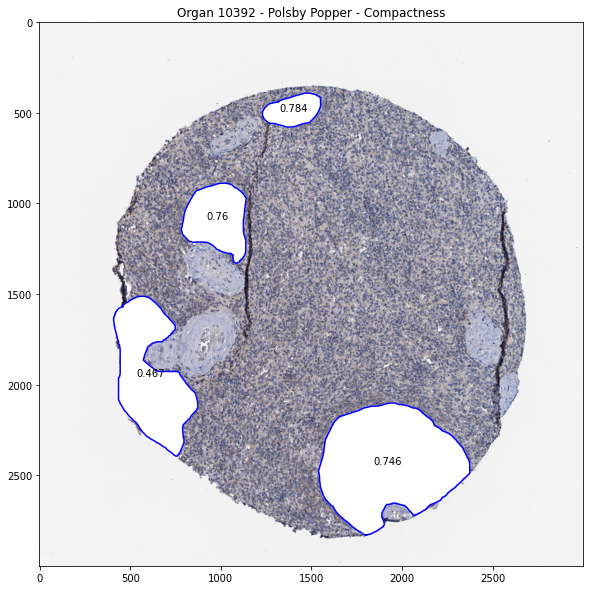

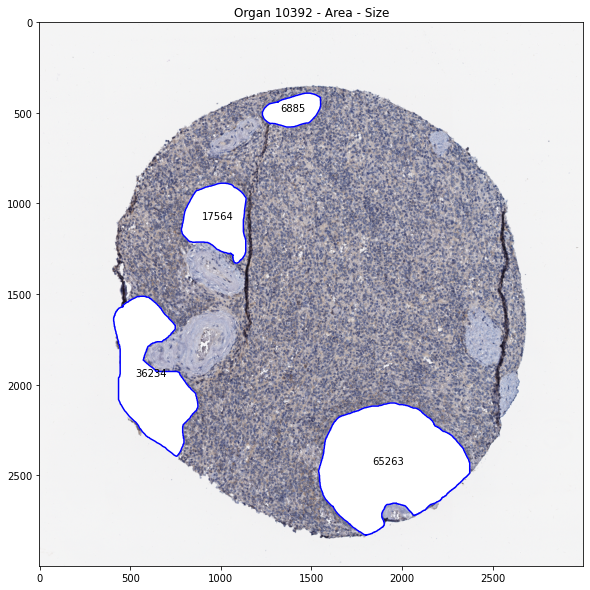

In [7]:
o = Organ(10392)
print(f"num FTUs: {len(o)}")
o.print_meta()
o.display("polsby_popper")
o.display("area")

num FTUs: 4
organ_type: kidney
pixel_size: 0.4
age: 68.0
sex: Female
data_source: HPA


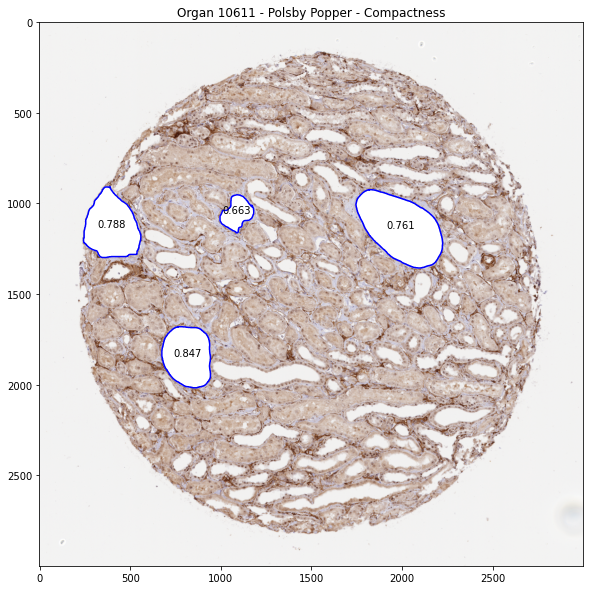

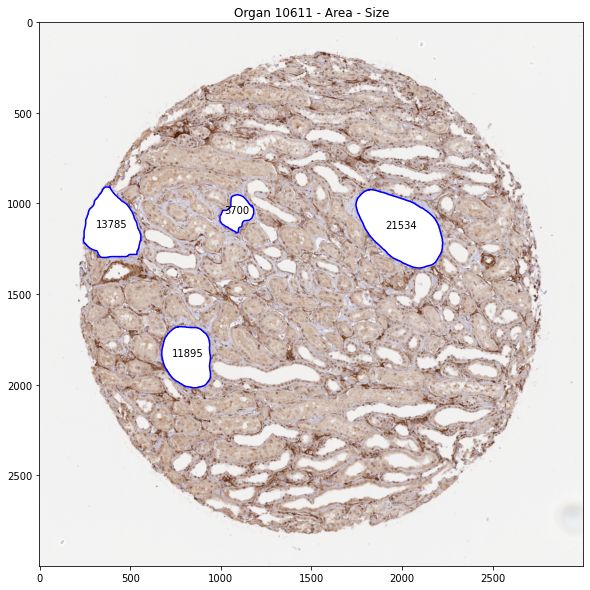

In [8]:
o = Organ(10611)
print(f"num FTUs: {len(o)}")
o.print_meta()
o.display("polsby_popper")
o.display("area")

num FTUs: 2
organ_type: lung
pixel_size: 0.4
age: 78.0
sex: Male
data_source: HPA


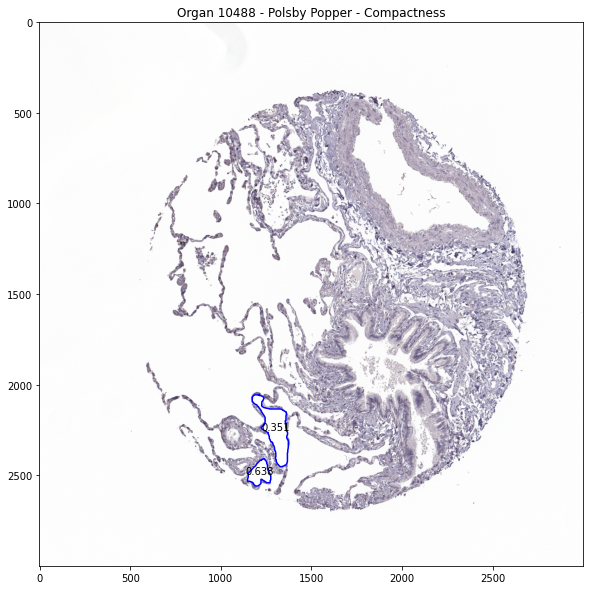

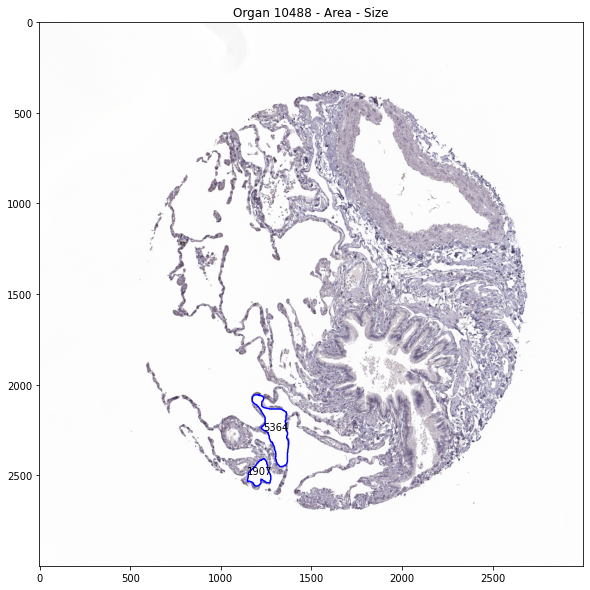

In [9]:
o = Organ(10488)
print(f"num FTUs: {len(o)}")
o.print_meta()
o.display("polsby_popper")
o.display("area")

num FTUs: 13
organ_type: largeintestine
pixel_size: 0.4
age: 83.0
sex: Male
data_source: HPA


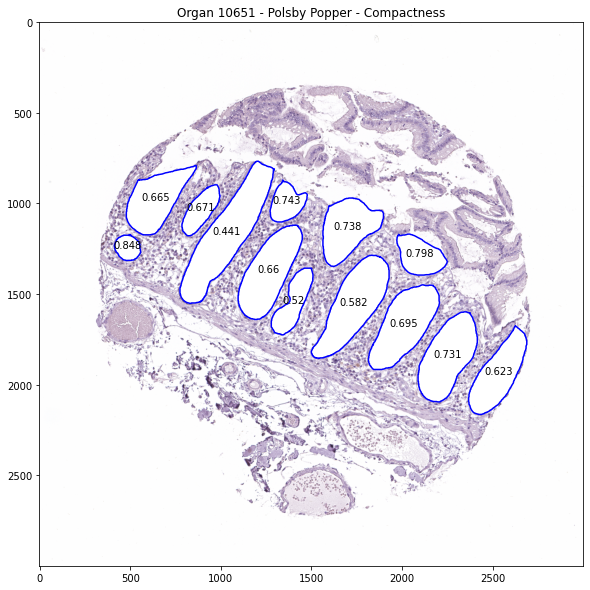

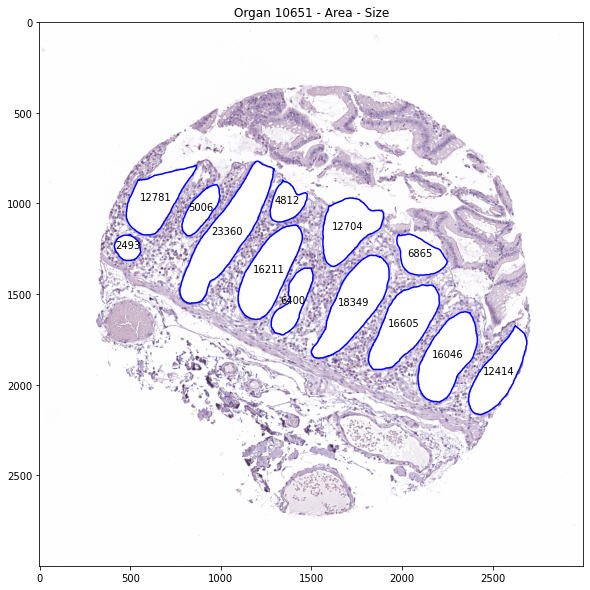

In [10]:
o = Organ(10651)
print(f"num FTUs: {len(o)}")
o.print_meta()
o.display("polsby_popper")
o.display("area")

In [11]:
def generate_dataset():
    ds = list()

    for img_id in meta.id:
        organ = Organ(img_id)
        for ftu in organ.polys:
            ds.append([img_id, organ.organ_type, organ.age, organ.sex, ftu.area, ftu.polsby_popper])

    return pd.DataFrame(ds, columns=["id", "organ", "age", "sex", "area", "polsby_popper"])

In [12]:
df = generate_dataset()

In [13]:
df.head()

id     organ   age   sex      area  polsby_popper
0  10044  prostate  37.0  Male  16902.88       0.597069
1  10044  prostate  37.0  Male  22069.92       0.712839
2  10044  prostate  37.0  Male  30340.32       0.609083
3  10044  prostate  37.0  Male  12206.08       0.702906
4  10044  prostate  37.0  Male  12498.72       0.711266

In [14]:
def plot_distrubutions(df):
    age = df.groupby("age")[["area", "polsby_popper"]].mean().reset_index()
    fig = px.bar(age.age, age.area)
    fig.update_xaxes(title="Mean Area (µm)")
    fig.update_yaxes(title="Age")
    fig.show()
    
    fig = px.bar(age.age, age.polsby_popper)
    fig.update_xaxes(title="Mean Polsby Popper (Compactness)")
    fig.update_yaxes(title="Age")
    fig.show()

In [15]:
plot_distrubutions(df)